# Mercari Price Prediction Project 
##  - Part 3 Data Processing, Machine Learning Modeling, and CNN without Word Embedding

<br> **Error Metric:** RMSLE (Root Mean Square Logarithmic Error)
<br>**Real world/Business Objectives and Constraints:**
<br> 1. Predict the price of an item given its condition, description and other related features.
<br> 2. Minimize the difference between predicted and actual price (RMSLE)
<br> 3. Try to provide some interpretability

 ## Import libraries

In [2]:
import numpy as np
import pandas as pd
import gc
import string
import re
from nltk.corpus import stopwords
import scipy
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# modeling
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# word embedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# tuning and processing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# support
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

/Users/inaba3910/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Data

In [2]:
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
train.shape, test.shape

((1482535, 16), (693359, 15))

## Text Preprocessing

In [3]:
# text preprocessing 
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [4]:
# preprocessing 'item_description' for train set
preprocessed_desc_train = []
for sentance in train['item_description'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub('[0-9]',' ',sent)
    sent = re.sub('[^0-9A-Za-z]+',' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_desc_train.append(sent.lower().strip())

# after preprocesing
preprocessed_desc_train[0]

'no description yet'

In [5]:
train['item_description'] = preprocessed_desc_train

In [6]:
# preprocessing 'name' for train set
preprocessed_name_train = []
for sentance in train['name'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub('[0-9]',' ',sent)
    sent = re.sub('[^0-9A-Za-z]+',' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_name_train.append(sent.lower().strip())

# after preprocesing
preprocessed_name_train[2]

'ava viv blouse'

In [7]:
train['name'] = preprocessed_name_train

In [8]:
#check before split
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
log_price            False
brand_name           False
shipping             False
item_description     False
name_len             False
desc_len             False
main_cat             False
subcat1              False
subcat2              False
negative             False
neutral              False
positive             False
compound             False
dtype: bool

In [9]:
# preprocessing 'item_description' for test set
preprocessed_desc_test = []
for sentance in test['item_description'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub('[0-9]',' ',sent)
    sent = re.sub('[^0-9A-Za-z]+',' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_desc_test.append(sent.lower().strip())
# after preprocesing
preprocessed_desc_test[20000]
test['item_description'] = preprocessed_desc_test

# preprocessing 'name' for test set
preprocessed_name_test = []
for sentance in test['name'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub('[0-9]',' ',sent)
    sent = re.sub('[^0-9A-Za-z]+',' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_name_test.append(sent.lower().strip())

# after preprocesing
preprocessed_name_test[20000]

test['name'] = preprocessed_name_test

In [10]:
test.isnull().any()

test_id              False
name                 False
item_condition_id    False
brand_name           False
shipping             False
item_description     False
name_len             False
desc_len             False
main_cat             False
subcat1              False
subcat2              False
negative             False
neutral              False
positive             False
compound             False
dtype: bool

## Splitting into train and test data set

In [11]:
# separate target variable and features for training
y_train = train['log_price']
train.drop(['train_id','log_price'], axis=1, inplace=True)

In [12]:
X=train 
y=y_train

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Data Processing on train and test datasets

### One-Hot-Encoding on Categorical Features using CountVectorizer

As observed from previous analysis, there are numbers of categorical variables in this dataset, and before moving into machine learning, we need to convert them into numerical format. Here, I chose to use One-Hot Encoding specifically done with respect to train data to avoid data leakage issue. I did not include test data into it because test data is unseen to us. So, if any category appears new while testing, we will ignore that value while converting to One-Hot encoded form.
<br>
<br>So, here we have ‘Brand Name’, ‘General Category’, ‘Sub category 1’, ‘Sub category 2’ as columns with categorical values. We will convert these categorical values into one-hot encoded form. 

In [14]:
#cleaning function
def clean_cat(cat_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(cat_values)

    cat_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list

In [15]:
# cleaning brand name before using count vectorizer
X_train['brand_name'] = clean_cat(X_train['brand_name'].values)
X_test['brand_name'] = clean_cat(X_test['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

100%|██████████| 693359/693359 [00:01<00:00, 540885.08it/s]


In [16]:
# one-hot encoding brand name
vectorizer = CountVectorizer(lowercase=False, binary=True)
xtrain_brand_onehot = vectorizer.fit_transform(X_train['brand_name'])
xtest_brand_onehot = vectorizer.transform(X_test['brand_name'])
test_brand_onehot = vectorizer.transform(test['brand_name'])

print("Shape of matrices after one hot encoding")
print(xtrain_brand_onehot.shape, "\n", xtest_brand_onehot.shape, "\n", test_brand_onehot.shape)

Shape of matrices after one hot encoding
(1037774, 4388) 
 (444761, 4388) 
 (693359, 4388)


In [17]:
# one-hot encoding main_cat
vectorizer = CountVectorizer(lowercase=False, binary=True)
xtrain_maincat_onehot = vectorizer.fit_transform(X_train['main_cat'].values)
xtest_maincat_onehot = vectorizer.transform(X_test['main_cat'].values)
test_maincat_onehot = vectorizer.transform(test['main_cat'].values)

print("Shape of matrices after one hot encoding")
print(xtrain_maincat_onehot.shape, "\n", xtest_maincat_onehot.shape, "\n", test_maincat_onehot.shape)

Shape of matrices after one hot encoding
(1037774, 12) 
 (444761, 12) 
 (693359, 12)


In [18]:
# one-hot encoding subcat1
vectorizer = CountVectorizer(lowercase=False, binary=True)
xtrain_subcat1_onehot = vectorizer.fit_transform(X_train['subcat1'].values)
xtest_subcat1_onehot = vectorizer.transform(X_test['subcat1'].values)
test_subcat1_onehot = vectorizer.transform(test['subcat1'].values)
print("Shape of matrices after one hot encoding")
print(xtrain_subcat1_onehot.shape, "\n", xtest_subcat1_onehot.shape, "\n", test_subcat1_onehot.shape)

Shape of matrices after one hot encoding
(1037774, 142) 
 (444761, 142) 
 (693359, 142)


In [19]:
# one-hot encoding subcat2
vectorizer = CountVectorizer(lowercase=False, binary=True)
xtrain_subcat2_onehot = vectorizer.fit_transform(X_train['subcat2'].values)
xtest_subcat2_onehot = vectorizer.transform(X_test['subcat2'].values)
test_subcat2_onehot = vectorizer.transform(test['subcat2'].values)

print("Shape of matrices after one hot encoding")
print(xtrain_subcat2_onehot.shape, "\n", xtest_subcat2_onehot.shape, "\n", test_subcat2_onehot.shape)

Shape of matrices after one hot encoding
(1037774, 951) 
 (444761, 951) 
 (693359, 951)


### Tfidf Vectorization on Text Features

The columns 'name' and 'item_description' were encoded into TF-IDF vectors of uni-grams, bi-grams and tri-grams. Note that using 1,2,3-grams together would result in a huge number of words in the dictionary of TF-IDF vectorizer and using all of them would result in very high dimensional vectors. To avoid this, I have limited the number of dimensions to 250k for name and 500k for item_description vectors.

In [20]:
# tfidf encoding 'name'
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)

xtrain_name_tfidf = tfidfvectorizer.fit_transform(X_train['name'].values)
xtest_name_tfidf = tfidfvectorizer.transform(X_test['name'].values)
test_name_tfidf = tfidfvectorizer.transform(test['name'].values)

print("Shape of matrices after vectorization")
print(xtrain_name_tfidf.shape, "\n", xtest_name_tfidf.shape, "\n", test_name_tfidf.shape)

Shape of matrices after vectorization
(1037774, 250000) 
 (444761, 250000) 
 (693359, 250000)


In [21]:
# tfidf encoding 'item_description'
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)
xtrain_desc_tfidf = tfidfvectorizer.fit_transform(X_train['item_description'].values)
xtest_desc_tfidf = tfidfvectorizer.transform(X_test['item_description'].values)
test_desc_tfidf = tfidfvectorizer.transform(test['item_description'].values)

print("Shape of matrices after vectorization")
print(xtrain_desc_tfidf.shape, "\n", xtest_desc_tfidf.shape, "\n", test_desc_tfidf.shape)

Shape of matrices after vectorization
(1037774, 500000) 
 (444761, 500000) 
 (693359, 500000)


### Normalize Numerical Features

The primary purpose of normalization is to scale numeric data from different columns down to an equivalent scale so that the model doesn’t get skewed due to huge variance in a few columns. I have used min-max normalization here because we need some power to supress the effect of outliers.

In [22]:
# pick up numerical columns
cols = set(X_train.columns.values)
skip_cols = {'item_condition_id', 'brand_name',
  'shipping', 'item_description', 'main_cat',
  'subcat1', 'subcat2','name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

# define min-max normalization funtion
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Normalizing following columns:  {'desc_len', 'compound', 'positive', 'negative', 'neutral', 'name_len'}


In [23]:
# normalize numerical features
xtrain_normalized = normalize(X_train)
xtest_normalized = normalize(X_test)
test_normalized = normalize(test)

### Consolidate All Features to a Sparse Matrix

In [24]:
# separating and storing all numerical features
X_xtrain = xtrain_normalized[list(cols_to_normalize)]
X_xtest = xtest_normalized[list(cols_to_normalize)]
X_test_x = test_normalized[list(cols_to_normalize)]

In [25]:
# storing categorical features to sparse matrix
X_xtrain_cat = csr_matrix(pd.get_dummies(xtrain_normalized[['item_condition_id', 'shipping']], sparse=True).values)
X_xtest_cat = csr_matrix(pd.get_dummies(xtest_normalized[['item_condition_id', 'shipping']], sparse=True).values)
X_test_cat = csr_matrix(pd.get_dummies(test_normalized[['item_condition_id', 'shipping']], sparse=True).values)
print(X_xtrain_cat.shape, X_xtest_cat.shape, X_test_cat.shape)

(1037774, 2) (444761, 2) (693359, 2)


In [26]:
# stack all categorical and text sparse matrices
xtrain_sparse = hstack((xtrain_brand_onehot, xtrain_maincat_onehot, xtrain_subcat1_onehot, xtrain_subcat2_onehot, \
              xtrain_name_tfidf, xtrain_desc_tfidf, X_xtrain_cat)).tocsr()
xtest_sparse = hstack((xtest_brand_onehot, xtest_maincat_onehot, xtest_subcat1_onehot, xtest_subcat2_onehot, \
             xtest_name_tfidf, xtest_desc_tfidf, X_xtest_cat)).tocsr()
test_sparse = hstack((test_brand_onehot, test_maincat_onehot, test_subcat1_onehot, test_subcat2_onehot, \
                      test_name_tfidf, test_desc_tfidf, X_test_cat)).tocsr()
print(xtrain_sparse.shape, xtest_sparse.shape, test_sparse.shape)

(1037774, 755495) (444761, 755495) (693359, 755495)


In [27]:
# stack dense feature matrix with categorical and text vectors
X_train = hstack((X_xtrain.values, xtrain_sparse)).tocsr()
X_test = hstack((X_xtest.values, xtest_sparse)).tocsr()
test_x = hstack((X_test_x.values, test_sparse)).tocsr()
print('Train size: {}, CV size: {}, Test size: {}' .format(X_train.shape, X_test.shape, test_x.shape))

Train size: (1037774, 755501), CV size: (444761, 755501), Test size: (693359, 755501)


In [28]:
# delete variables we do not need further
del vectorizer
del xtrain_normalized, xtest_normalized, test_normalized
del xtrain_brand_onehot, xtrain_maincat_onehot, xtrain_subcat1_onehot, xtrain_subcat2_onehot, X_xtrain_cat,xtrain_name_tfidf, xtrain_desc_tfidf

del xtest_brand_onehot, xtest_maincat_onehot, xtest_subcat1_onehot, xtest_subcat2_onehot, X_xtest_cat, xtest_name_tfidf, xtest_desc_tfidf

del test_brand_onehot, test_maincat_onehot, test_subcat1_onehot, test_subcat2_onehot, X_test_cat, test_name_tfidf, test_desc_tfidf
gc.collect()

60

## Define Error Metric

In [29]:
def rmsle(y, y_pred): # return Rmsle value.
    return np.sqrt(np.mean(np.square(y_pred - y )))

## Machine Learning Modeling Experiments

In this section, I chose to use ridge regression, lasso regression, light gradient boosting regressor, and xgboost regressor with randomized search for hyperparameter tuning as 4 of the machine learning models. These were chosen particularly because we need fast and robust regression model towards price, and we need a model with a high performance so some models like random forest that is known better performed in categorization problems are excluded.

### Ridge Regression

In [39]:
# prepare lasso regression and use randomized search for hyperparameter tuning
# here, use parallel_backend to boost speed and avoid no end tuning process
from sklearn.externals.joblib import parallel_backend
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
              'fit_intercept' : [False],
              'solver' : ['lsqr']}
model = Ridge()
rs_ridge = RandomizedSearchCV(model,
                        param_distributions = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 100,
                        return_train_score = True,
                        n_iter=10, 
                        random_state=42)

with parallel_backend('threading'):
    rs_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[CV] solver=lsqr, fit_intercept=False, alpha=0.0001 ..................[CV] solver=lsqr, fit_intercept=False, alpha=0.0001 ..................

[CV] solver=lsqr, fit_intercept=False, alpha=0.0001 ..................
[CV] solver=lsqr, fit_intercept=False, alpha=0.001 ...................
[CV] solver=lsqr, fit_intercept=False, alpha=0.001 ...................
[CV] solver=lsqr, fit_intercept=False, alpha=0.001 ...................
[CV] solver=lsqr, fit_intercept=False, alpha=0.01 ....................[CV] solver=lsqr, fit_intercept=False, alpha=0.01 ....................

[CV]  solver=lsqr, fit_intercept=False, alpha=0.001, score=(train=-0.198, test=-0.223), total=23.3min[CV]  solver=lsqr, fit_intercept=False, alpha=0.0001, score=(train=-0.198, test=-0.223), total=23.3min

[CV] solver=lsqr, fit_intercept=False, alpha=0.01 ....................[CV] solver=lsqr

In [40]:
print('Best parameters found by random search are:', rs_ridge.best_params_)
print('Best score found by random search is:', rs_ridge.best_score_)

Best parameters found by random search are: {'solver': 'lsqr', 'fit_intercept': False, 'alpha': 1}
Best score found by random search is: -0.2232724389821035


In [41]:
# fit and get rmsle
ridgeReg = Ridge(alpha=1,solver = "lsqr", fit_intercept=False )
ridgeReg.fit(X_train, y_train)
y_pred_ridge = ridgeReg.predict(X_test)

In [42]:
ridge_RMSLE = rmsle(y_test, y_pred_ridge)
print(' Fold %02d Ridge RMSLE: ', ridge_RMSLE)

 Fold %02d Ridge RMSLE:  0.48015452226677147


### Lasso Regression

In [33]:
# prepare lasso regression and use randomized search for hyperparameter tuning
# here, use parallel_backend to boost speed and avoid no end tuning process
from sklearn.externals.joblib import parallel_backend
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
              'fit_intercept' : [False]}
model = Lasso()
rs_lasso = RandomizedSearchCV(model,
                        param_distributions = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 100,
                        return_train_score = True,
                        n_iter=10, 
                        random_state=42)

with parallel_backend('threading'):
    rs_lasso.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[CV] fit_intercept=False, alpha=0.0001 ...............................[CV] fit_intercept=False, alpha=0.0001 ...............................
[CV] fit_intercept=False, alpha=0.0001 ...............................

[CV] fit_intercept=False, alpha=0.001 ................................[CV] fit_intercept=False, alpha=0.001 ................................
[CV] fit_intercept=False, alpha=0.001 ................................
[CV] fit_intercept=False, alpha=0.01 .................................
[CV] fit_intercept=False, alpha=0.01 .................................

[CV]  fit_intercept=False, alpha=0.01, score=(train=-0.505, test=-0.505), total= 2.9min
[CV]  fit_intercept=False, alpha=0.01, score=(train=-0.505, test=-0.508), total= 2.9min
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[CV] fit_intercept=False, alpha=0.1 .................

In [34]:
print('Best parameters found by random search are:', rs_lasso.best_params_)
print('Best score found by random search is:', rs_lasso.best_score_)

Best parameters found by random search are: {'fit_intercept': False, 'alpha': 0.0001}
Best score found by random search is: -0.3074479111859845


In [35]:
# fit and get rmsle
lassoReg = Lasso(alpha=0.0001, fit_intercept=False )
lassoReg.fit(X_train, y_train)
y_pred_lasso = lassoReg.predict(X_test)

In [37]:
lasso_RMSLE = rmsle(y_test, y_pred_lasso)
print(' Fold %02d Lasso RMSLE: ', lasso_RMSLE)

 Fold %02d Lasso RMSLE:  0.556302994133279


### Light GBM Regressor

In [43]:
# prepare lightGBM regressor and use randomized search for hyperparameter tuning
# instead of grid search, randmized search is more effective and time saving in my models
# here, use parallel_backend to boost speed and avoid no end tuning process
rsParams = {'learning_rate': uniform(0, 0.5),
          'n_estimators': sp_randint(200, 500),
          'num_leaves': sp_randint(20, 100),
          'max_depth': sp_randint(2, 8)
           }
lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression'
        }
model = LGBMRegressor(**lgbm_params)

rs_lgbm = RandomizedSearchCV(model, param_distributions=rsParams, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_mean_squared_error', verbose=10, return_train_score=True)

with parallel_backend('threading'):
    rs_lgbm.fit(X_train, y_train)

print('Best parameters found by random search are:', rs_lgbm.best_params_)
print('Best score found by random search is:', rs_lgbm.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV] learning_rate=0.18727005942368125, max_depth=6, n_estimators=470, num_leaves=91 [CV] learning_rate=0.18727005942368125, max_depth=6, n_estimators=470, num_leaves=91 

[CV] learning_rate=0.18727005942368125, max_depth=6, n_estimators=470, num_leaves=91 [CV] learning_rate=0.2993292420985183, max_depth=3, n_estimators=414, num_leaves=94 
[CV] learning_rate=0.2993292420985183, max_depth=3, n_estimators=414, num_leaves=94 

[CV] learning_rate=0.2993292420985183, max_depth=3, n_estimators=414, num_leaves=94 [CV] learning_rate=0.22962444598293358, max_depth=6, n_estimators=299, num_leaves=43 

[CV] learning_rate=0.22962444598293358, max_depth=6, n_estimators=299, num_leaves=43 
[CV]  learning_rate=0.2993292420985183, max_depth=3, n_estimators=414, num_leaves=94, score=(train=-0.266, test=-0.273), total= 9.2min
[CV]  learning_rate=0.2993292420985183, max_depth=3, n_estimators=414, num_leaves=94, score=(train=-0.268, test=-0.270), total= 9.2min[CV]  learning_rate=0.2993292420985183, max_de

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.7min


[CV] learning_rate=0.22962444598293358, max_depth=6, n_estimators=299, num_leaves=43 
[CV] learning_rate=0.32544423647442644, max_depth=6, n_estimators=457, num_leaves=49 
[CV] learning_rate=0.32544423647442644, max_depth=6, n_estimators=457, num_leaves=49 
[CV]  learning_rate=0.22962444598293358, max_depth=6, n_estimators=299, num_leaves=43, score=(train=-0.249, test=-0.260), total=26.5min
[CV] learning_rate=0.32544423647442644, max_depth=6, n_estimators=457, num_leaves=49 
[CV]  learning_rate=0.22962444598293358, max_depth=6, n_estimators=299, num_leaves=43, score=(train=-0.250, test=-0.258), total=27.0min
[CV] learning_rate=0.10616955533913808, max_depth=5, n_estimators=476, num_leaves=52 
[CV]  learning_rate=0.18727005942368125, max_depth=6, n_estimators=470, num_leaves=91, score=(train=-0.242, test=-0.250), total=39.2min
[CV]  learning_rate=0.18727005942368125, max_depth=6, n_estimators=470, num_leaves=91, score=(train=-0.240, test=-0.253), total=39.2min
[CV] learning_rate=0.10616

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 45.7min


[CV] learning_rate=0.15212112147976886, max_depth=7, n_estimators=452, num_leaves=68 
[CV]  learning_rate=0.32544423647442644, max_depth=6, n_estimators=457, num_leaves=49, score=(train=-0.225, test=-0.238), total=40.9min
[CV]  learning_rate=0.32544423647442644, max_depth=6, n_estimators=457, num_leaves=49, score=(train=-0.224, test=-0.242), total=41.0min
[CV] learning_rate=0.15212112147976886, max_depth=7, n_estimators=452, num_leaves=68 
[CV] learning_rate=0.2623873301291946, max_depth=3, n_estimators=387, num_leaves=99 
[CV]  learning_rate=0.10616955533913808, max_depth=5, n_estimators=476, num_leaves=52, score=(train=-0.271, test=-0.275), total=34.0min
[CV] learning_rate=0.2623873301291946, max_depth=3, n_estimators=387, num_leaves=99 
[CV]  learning_rate=0.2623873301291946, max_depth=3, n_estimators=387, num_leaves=99, score=(train=-0.275, test=-0.277), total=12.6min
[CV] learning_rate=0.2623873301291946, max_depth=3, n_estimators=387, num_leaves=99 
[CV]  learning_rate=0.32544423

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 101.8min remaining: 59.0min


[CV] learning_rate=0.09983689107917987, max_depth=5, n_estimators=330, num_leaves=70 
[CV]  learning_rate=0.15212112147976886, max_depth=7, n_estimators=452, num_leaves=68, score=(train=-0.239, test=-0.253), total=59.0min
[CV] learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37 
[CV]  learning_rate=0.09983689107917987, max_depth=5, n_estimators=330, num_leaves=70, score=(train=-0.288, test=-0.291), total=30.9min
[CV] learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37 
[CV]  learning_rate=0.15212112147976886, max_depth=7, n_estimators=452, num_leaves=68, score=(train=-0.241, test=-0.250), total=57.5min
[CV] learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37 
[CV]  learning_rate=0.09983689107917987, max_depth=5, n_estimators=330, num_leaves=70, score=(train=-0.287, test=-0.294), total=31.0min


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 115.6min remaining: 35.2min


[CV]  learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37, score=(train=-0.289, test=-0.290), total=10.5min
[CV]  learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37, score=(train=-0.286, test=-0.292), total= 7.2min
[CV]  learning_rate=0.11638567021515211, max_depth=7, n_estimators=374, num_leaves=81, score=(train=-0.257, test=-0.264), total=48.6min
[CV]  learning_rate=0.34015376929388985, max_depth=2, n_estimators=366, num_leaves=37, score=(train=-0.288, test=-0.288), total= 5.1min


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 120.0min remaining: 13.3min


[CV]  learning_rate=0.09983689107917987, max_depth=5, n_estimators=330, num_leaves=70, score=(train=-0.289, test=-0.290), total=18.7min
[CV]  learning_rate=0.11638567021515211, max_depth=7, n_estimators=374, num_leaves=81, score=(train=-0.258, test=-0.263), total=44.3min
[CV]  learning_rate=0.11638567021515211, max_depth=7, n_estimators=374, num_leaves=81, score=(train=-0.255, test=-0.267), total=44.8min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 121.4min finished


Best parameters found by random search are: {'learning_rate': 0.32544423647442644, 'max_depth': 6, 'n_estimators': 457, 'num_leaves': 49}
Best score found by random search is: -0.23973342852724522


In [44]:
# fit and get rmsle
lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression','boosting_type': 'gbdt','learning_rate': 0.32544423647442644,'max_depth': 6,'n_estimators': 457,'num_leaves': 49,
      }
lgbm_reg = LGBMRegressor(**lgbm_params)
lgbm_reg.fit(X_train, y_train, verbose=True)

y_pred_lgbm = lgbm_reg.predict(X_test)

In [45]:
lgbm_RMSLE = rmsle(y_test, y_pred_lgbm)
print(' Fold Light GMB RMSLE: ', lgbm_RMSLE)

 Fold Light GMB RMSLE:  0.48670853024263994


### XGBoost Regressor

In [30]:
# prepare XGBoost regressor and use randomized search for hyperparameter tuning
from sklearn.externals.joblib import parallel_backend
xgbr = xgb.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5,7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.3,0.7],
              'n_estimators': [50,100]}
rs_xgb = RandomizedSearchCV(xgbr, param_distributions=parameters, cv=3, n_iter=10,
                            verbose=100, return_train_score=True)


with parallel_backend('threading'):
    rs_xgb.fit(X_train, y_train)
    


print('Best parameters found by random search are:', rs_xgb.best_params_)
print('Best score found by random search is:', rs_xgb.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[CV] subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.7 [CV] subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.7 
[CV] subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.7 

[CV] subsample=0.7, objective=reg:linear, n_estimators=50, min_child_weight=4, max_depth=5, learning_rate=0.07, colsample_bytree=0.7 
[CV] subsample=0.7, objective=reg:linear, n_estimators=50, min_child_weight=4, max_depth=5, learning_rate=0.07, colsample_bytree=0.7 
[CV] subsample=0.7, objective=reg:linear, n_estimators=50, min_child_weight=4, max_depth=5, learning_rate=0.07, colsample_bytree=0.7 
[CV] subsample=0.7, objective=reg:linear, n_estimat

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 51.1min remaining: 29.6min
[CV] subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.3 
[CV]  subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.07, colsample_bytree=0.3, score=(train=0.417, test=0.411), total=13.7min
[CV]  subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.05, colsample_bytree=0.3, score=(train=0.384, test=0.381), total=13.1min
[CV]  subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.05, colsample_bytree=0.3, score=(train=0.385, test=0.381), total=13.6min[Parallel(n_jobs=-1)]: Done  20 out of  30 | elapsed: 52.4min remaining: 26.2min

[CV]  subsample=0.7, objective=reg:linear, n_estimators=100, min_child_weight=4, max_depth=7, learning_rate=0.05, colsample_bytree=0.7, score=(train=0.390

In [32]:
# fit and get rmsle 
xgb_param ={'subsample': 0.7, 'objective': 'reg:linear', 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.07, 'colsample_bytree': 0.3}
xgb_reg = xgb.XGBRegressor(**rsreg_param)
xgb_reg.fit(X_train, y_train)

[18:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:19] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
y_pred_xgb = xgb_reg.predict(X_test)
xgb_RMSLE = rmsle(y_test, y_pred_xgb)
print(xgb_RMSLE)

0.5776107097698279


## Deep Learning Modeling Experiments

Based on existing methods, I would like to try several models with/without different word embedding methods with Convolutional Neural Networks to see if I can get a lower RMSLE value compared to results from machine learning models. Below I chose to use CNN because it is faster than LSTM according to existing modeling results from others, but it would be interesting to try LSTM in the future for improvements.
<br>
<br> In this notebook, I only show a CNN model without word embedding (tokenization only on "name" and "item description" columns). In Part 4, I will specifically show 4 ways of embeddings with CNN.

### Preprocessing
Mostly same as what I did for machine learning preprocessing.

In [3]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy.random import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Activation, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers import concatenate, BatchNormalization
from keras import optimizers
from keras.models import Model

In [3]:
# load datasets
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_train.csv')
train.shape, test.shape

((1482535, 16), (1482535, 16))

In [5]:
# split target variable and train dataset
y_train = train['log_price']
train.drop(['train_id','log_price'], axis=1, inplace=True)

In [6]:
# normalize numerical features using min-max normalization
cols = set(train.columns.values)
skip_cols = {'item_condition_id', 'brand_name',
  'shipping', 'item_description', 'main_cat',
  'subcat1', 'subcat2','name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result=df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

train = normalize(train)
test = normalize(test)

Normalizing following columns:  {'negative', 'name_len', 'positive', 'neutral', 'desc_len', 'compound'}


In [38]:
def clean_cat(cat_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(cat_values)

    cat_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list

# Cleaning brand name before using count vectorizer
# Using same preprocessing as used earlier for categories: 'clean_cat()' function

train['brand_name'] = clean_cat(train['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

100%|██████████| 1482535/1482535 [00:03<00:00, 492239.09it/s]


In [109]:
# encoding categorical variables for embedding
label = LabelEncoder()

label.fit(train.brand_name) # brand name 
train.brand_name = label.transform(train.brand_name)

label.fit(train.main_cat) # sub_cat0
train.main_cat = label.transform(train.main_cat)

label.fit(train.subcat1) # sub_cat_1
train.subcat1 = label.transform(train.subcat1)

label.fit(train.subcat2) # sub_cat2
train.subcat2 = label.transform(train.subcat2)

del label

As shown above, I chose to encode categorical variables using label encoder because I want to avoid high memory consumption that could lead to slow training on deep learning models. It is better to use a one-hot-encoding if possible, as the categories are not ordinal.

In [4]:
# define function to preprocess "name"
def preprocess_name(text_col):
    preprocessed_names = []
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_names.append(sent.lower().strip())
    return preprocessed_names

# preprocess "name"
train['name'] = preprocess_name(train['name'])
test['name'] = preprocess_name(test['name'])

100%|██████████| 1482535/1482535 [00:05<00:00, 279610.01it/s]


In [151]:
# text to Sequence Data.
# combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])
# full_text_test = np.hstack([test.item_description.str.lower(), test.name.str.lower()])

In [152]:
# tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower())

In [153]:
# finding out max len of all the text data combined
max_len_brand = np.max(train.brand_name.max())    # brand 
max_len_condition = np.max(int(max(train.item_condition_id)))  # item_condition
max_len_desc = np.max(int(train.desc_len.max()))  # desc_len
max_len_name = np.max(int(train.name_len.max()))  # name_len
max_len_sub0 = np.max(int(train.main_cat.max()))  # main_cat
max_len_sub1 = np.max(int(train.subcat1.max()))  # Sub_1
max_len_sub2 = np.max(train.subcat2.max())  # Sub_2
# defining max length for padding text data
name_padding = 15
description_padding = 80
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),])

In [154]:
# train and test split
x_tr, x_te, Y_train, Y_test = train_test_split(train,y_train, random_state=42, train_size=0.7)
Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

### CNN without word embeddings as weights

In [155]:
# padding
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_tr.brand_name),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.main_cat),
"subcat_1"  : np.array(x_tr.subcat1),
"subcat_2" : np.array(x_tr.subcat2),
} 
x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_te.brand_name),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.main_cat),
"subcat_1" : np.array(x_te.subcat1),
"subcat_2" : np.array(x_te.subcat2),
}

In [156]:
x_tr = x_train_padded
x_te = x_test_padded

In [157]:
# define attributes
batch_size = 512 * 3
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(x_tr['name']) / batch_size) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

In [245]:
# definign inputs
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name = Input(shape=[1], name="brand_name")

num_vars = Input(shape=[1], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]

In [232]:
# define embedding layers, max lengthes raised larger becuase of the system error using tensorflow 2.x
sub0_emb = Embedding(max_len_sub0+10, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1+10, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2+10, 10)(subcat_2)

brand_emb = Embedding(max_len_brand+10, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition+10, 5)(item_condition)

name_emb = Embedding(max_len+10, 15, weights=[embedding_matrix])(name)
item_desc_emb = Embedding(max_len+10, 80, weights=[embedding_matrix])(item_desc)

desc_len_emb = Embedding(max_len_desc+10, 5)(desc_len)
name_len_emb = Embedding(max_len_name+10, 5)(name_len)

In [216]:
# cnn and pooling layers
convs1 = []
convs2 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

In [217]:
convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

In [218]:
# flatten
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [111]:
# concatenate for further steps
main_l = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,embed_1,convs1,convs2, num_vars])

In [220]:
# add dropout and batchnormalization layers
main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

In [221]:
# define output layer and optimizer
output = Dense(1, activation="linear") (main_l)
model_2 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars ], output)
optimizer = optimizers.Adam(lr = 0.005)
# compile the model
model_2.compile(loss = 'mse', optimizer = optimizer)
model_2.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_104 (Embedding)       (None, 15, 15)       3749190     name[0][0]                       
__________________________________________________________________________________________________
embedding_105 (Embedding)       (None, 80, 80)       19995680    item_desc[0][0]                  
______________________________________________________________________________________

In [222]:
# fit cnn model
model_2.fit(x_tr, Y_train, epochs= 2, batch_size= 512 * 3)

Epoch 1/2
676/676 [==============================] - 260s 385ms/step - loss: 0.5104
Epoch 2/2
676/676 [==============================] - 248s 367ms/step - loss: 0.1813


In [225]:
# get the error
y_pred = model_2.predict(x_te, batch_size=batch_size)
print("RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.45484033271260815


## Model Comparison and Take Aways

In [131]:
scores = {}
scores['ridge'] = 0.47
scores['lightGBM'] = 0.48
scores['randome forest'] = 0.7
scores['cnn'] = 0.45

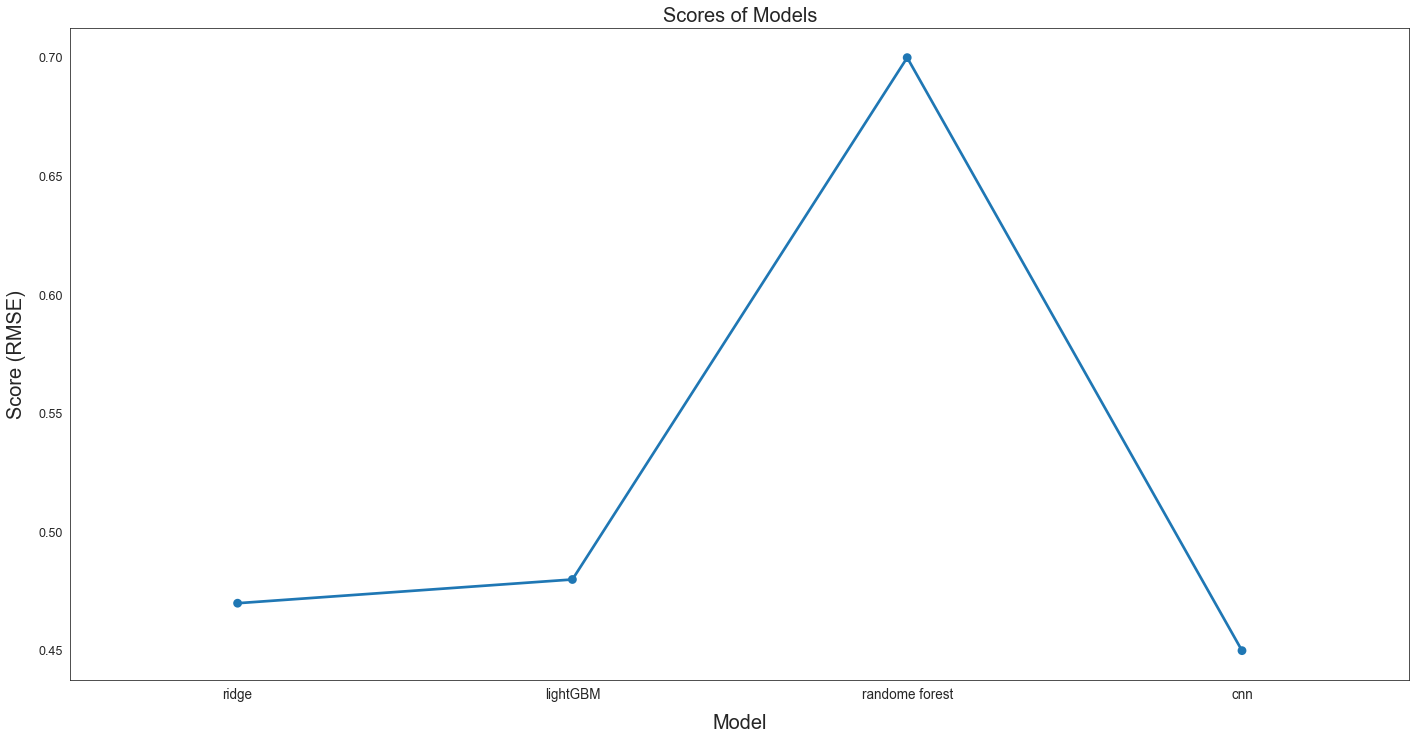

In [136]:
# plot RMSEs
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y= list(scores.values()), markers=['o'], linestyles=['-'])
# for i, score in enumerate(scores.values()):
#     ax.text(i, score + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

It is obvious that in machine learning methods, ridge regression did the best. And generally speaking, deep learning in cnn model performed the best among all models.

As for future works, multi-layer percepton model is very attrctive to try since it does not envolve a lot of calculations and it is time-saving as well. On the other hand, to get more information from the modeling results, it is attempting to map column names to sparse matrix and then get the most important coefficients from the fitted ridge regression model.